In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from numpy.fft import fft, fftfreq

In [28]:
# Load the dataset
file_path = "acquisitions/synthetic_test/processed/processed_all_actions.csv"

# Import the CSV file into a DataFrame
data = pd.read_csv(file_path)

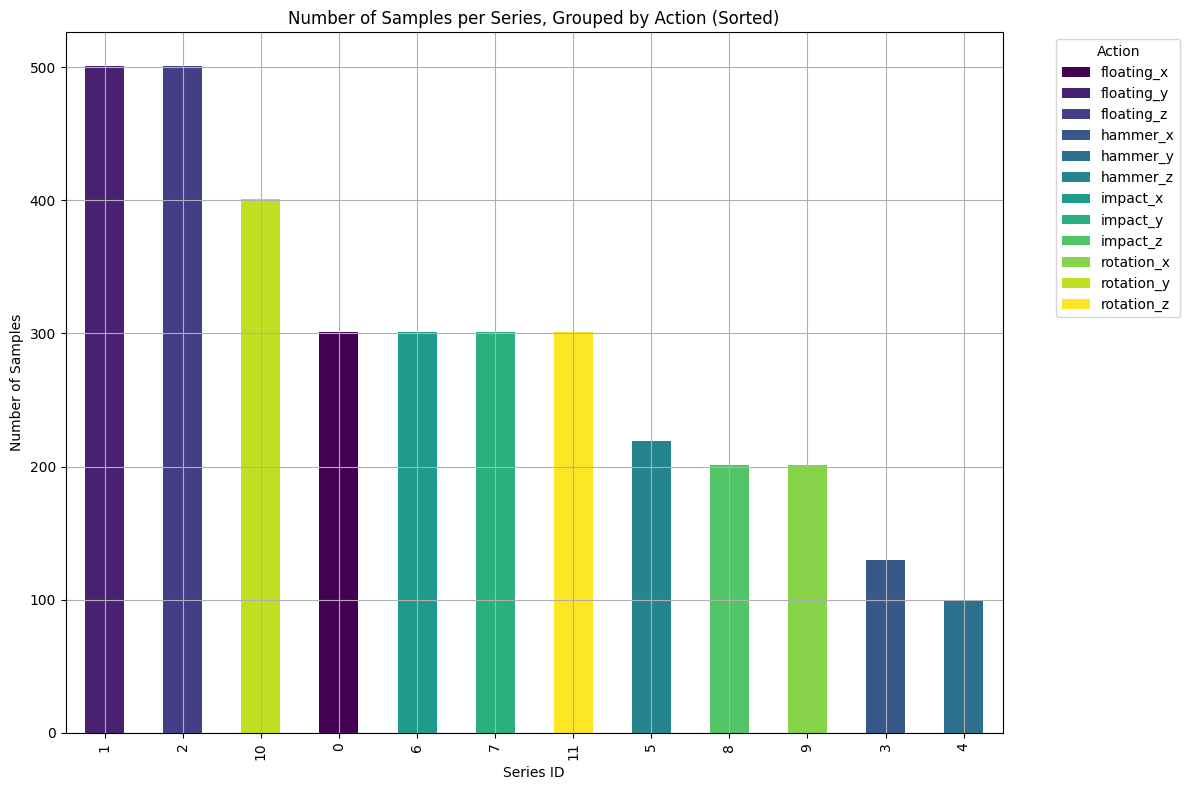

In [40]:
# Grouping data by series_id and action
grouped_data = data.groupby(['series_id', 'action']).size().unstack(fill_value=0)

# Sorting the grouped data by the total number of samples in each series, from highest to lowest
sorted_grouped_data = grouped_data.sum(axis=1).sort_values(ascending=False)
sorted_grouped_data = grouped_data.loc[sorted_grouped_data.index]

# Plotting the sorted histogram
ax = sorted_grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Number of Samples per Series, Grouped by Action (Sorted)')
plt.xlabel('Series ID')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [30]:
# Convert '_time' to datetime and calculate time differences
data['_time'] = pd.to_datetime(data['_time'])
data['time_diff'] = data.groupby('series_id')['_time'].diff()

# Dropping NaN values
data_cleaned = data.dropna()

# Converting the time differences from timedelta to float (in seconds) for easier plotting
data_cleaned['time_diff_seconds'] = data_cleaned['time_diff'].dt.total_seconds()

C:\Users\MegaN\AppData\Local\Temp\ipykernel_4864\3005622164.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['time_diff_seconds'] = data_cleaned['time_diff'].dt.total_seconds()


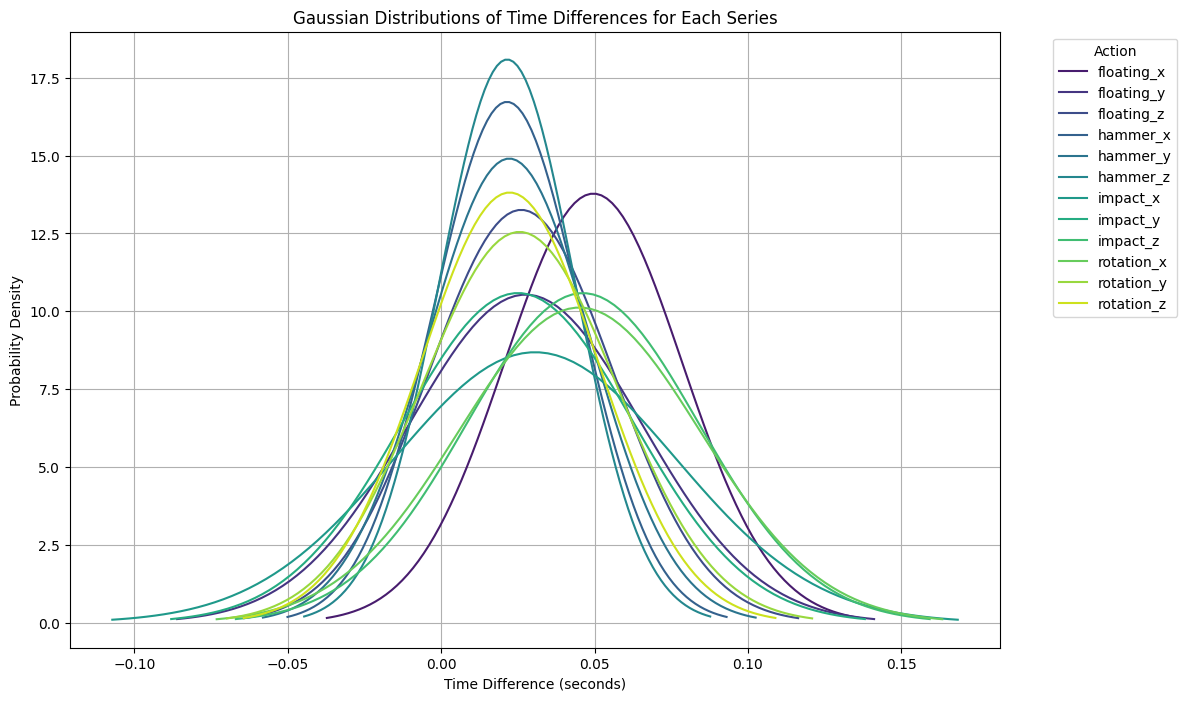

In [50]:
# Create a mapping of series_id to action
action_mapping = data_cleaned.dropna().groupby('series_id')['action'].first().to_dict()

# Setting up the color palette to match the histogram colors
palette = sns.color_palette('viridis', n_colors=len(data_cleaned['series_id'].unique()))

# Plotting Gaussian distributions with the same colors as the histogram
plt.figure(figsize=(12, 8))

# Generating Gaussian plots for each series
for idx, series_id in enumerate(sorted(data_cleaned['series_id'].unique())):
    # Selecting the series
    series_data = data_cleaned[data_cleaned['series_id'] == series_id]['time_diff_seconds']
    
    # Calculating mean and standard deviation
    mean = series_data.mean()
    std = series_data.std()
    
    # Generating points for the Gaussian curve
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    
    # Plotting with action name in the label
    action_name = action_mapping.get(series_id, 'Unknown')
    plt.plot(x, y, label=f'{action_name}', color=palette[idx])

# Adding title, labels, and legend
plt.title('Gaussian Distributions of Time Differences for Each Series')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Probability Density')
plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show plot
plt.show()


In [59]:
# print the mean and standard deviation of the time differences for each series
series_mean = []
series_std = []

for series_id in data_cleaned['series_id'].unique():
    series_data = data_cleaned[data_cleaned['series_id'] == series_id]['time_diff_seconds']
    series_mean.append(series_data.mean())
    series_std.append(series_data.std())
    print(f'Series {series_id}: mean = {series_data.mean()}, std = {series_data.std()}')

print('-------------------')

# print minimum and maximum mean and standard deviation
print(f'Minimum mean: {min(series_mean)}')
print(f'Maximum mean: {max(series_mean)}')
print(f'Minimum std: {min(series_std)}')
print(f'Maximum std: {max(series_std)}')

print('-------------------')

sampling_time = round(min(series_mean), 2)
print(f'Sampling time: {sampling_time} seconds')

Series 0: mean = 0.04959692666666667, std = 0.028955342144013397
Series 1: mean = 0.027511970000000004, std = 0.03786846571124512
Series 2: mean = 0.026084467999999996, std = 0.030094336600227485
Series 3: mean = 0.021462023255813957, std = 0.023854636349822385
Series 4: mean = 0.022189438775510207, std = 0.026768706263315695
Series 5: mean = 0.021507, std = 0.022060028831696925
Series 6: mean = 0.030586783333333336, std = 0.045933133781250725
Series 7: mean = 0.025045226666666667, std = 0.037686705165563036
Series 8: mean = 0.046150395, std = 0.037697013358883945
Series 9: mean = 0.045073755, std = 0.03941988182925128
Series 10: mean = 0.025535295000000003, std = 0.03179207141750147
Series 11: mean = 0.022298380000000003, std = 0.028880091391560433
-------------------
Minimum mean: 0.021462023255813957
Maximum mean: 0.04959692666666667
Minimum std: 0.022060028831696925
Maximum std: 0.045933133781250725
-------------------
Sampling time: 0.02 seconds


In [79]:
feature_plot = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

# function to plot acceleration data for a given series
def plot_acceleration_data(series_id):
    # Selecting the series
    series_data = data_cleaned[data_cleaned['series_id'] == series_id]
    
    # Plotting the acceleration data in a 2x3 grid
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f'Acceleration Data for Series {series_id} - {action_mapping.get(series_id, "Unknown")}')

    # Plotting each feature
    for idx, feature in enumerate(feature_plot):
        # Calculating the row and column index
        row = idx // 3
        col = idx % 3
        
        # Plotting the feature
        axs[row, col].plot(series_data['measurement_id'], series_data[feature])
        axs[row, col].set_title(feature)
        axs[row, col].set_xlabel('Measurement ID')
        if row == 0:
            axs[row, col].set_ylabel('Acceleration (g)')
        else:
            axs[row, col].set_ylabel('Angular Velocity (deg/s)')
        axs[row, col].grid(True)        

    # Adjusting the spacing between plots
    fig.tight_layout(pad=3.0)

    # Show plot
    plt.show()

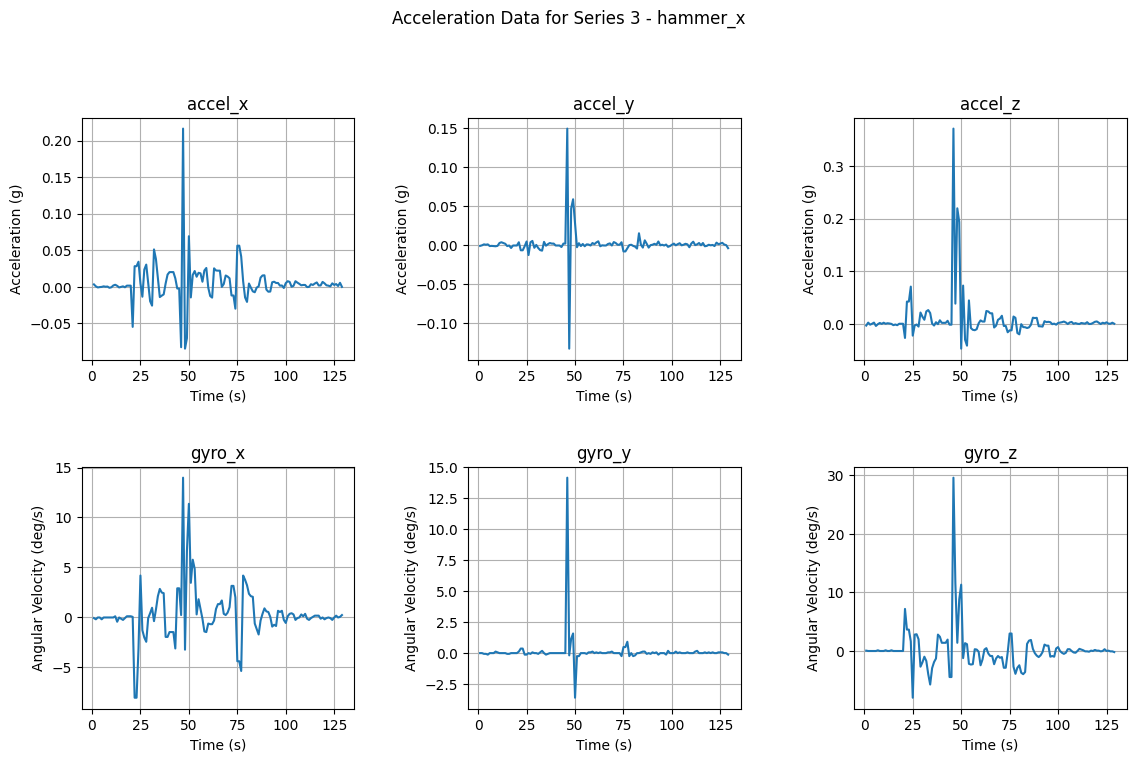

In [80]:
plot_acceleration_data(3)